In [3]:
import os
import gdown
import pandas as pd

# gdown kütüphanesini yükleyin
os.system('pip install gdown')

# Google Drive dosya URL'si ve dosya ID'si
url = 'https://drive.google.com/uc?id=1GdMMm_e2nwbtrK_PpSP21ab5poiB-qQK'
output = 'amazon_reviews.csv'

# Dosyayı indir
gdown.download(url, output, quiet=False)

# Veriyi okuma
data = pd.read_csv(output)

Downloading...
From: https://drive.google.com/uc?id=1GdMMm_e2nwbtrK_PpSP21ab5poiB-qQK
To: C:\Users\Modalog\amazon_reviews.csv
100%|██████████| 1.60M/1.60M [00:00<00:00, 4.88MB/s]


In [4]:
# Eksik değer analizi
# Eksik değerlerin sayısını ve yüzdesini hesaplama
missing_values = data.isnull().sum()
missing_percentage = (data.isnull().sum() / len(data)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_percentage
})

print(missing_df)

# Aşırı değer analizi
# Sadece sayısal sütunları seçme
numeric_cols = data.select_dtypes(include=['float64', 'int64'])

# IQR yöntemi ile aşırı değerleri tespit etme
Q1 = numeric_cols.quantile(0.25)
Q3 = numeric_cols.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_df = ((numeric_cols < lower_bound) | (numeric_cols > upper_bound)).sum()

print(outliers_df)

# Gereksiz sütunların kaldırılması
# 'Unnamed: 0' sütununun veri setinde olup olmadığını kontrol edip kaldırma
if 'Unnamed: 0' in data.columns:
    data.drop(columns=['Unnamed: 0'], inplace=True)

                      Missing Values  Percentage (%)
Unnamed: 0                         0        0.000000
reviewerName                       1        0.020346
overall                            0        0.000000
reviewText                         1        0.020346
reviewTime                         0        0.000000
day_diff                           0        0.000000
helpful_yes                        0        0.000000
helpful_no                         0        0.000000
total_vote                         0        0.000000
score_pos_neg_diff                 0        0.000000
score_average_rating               0        0.000000
wilson_lower_bound                 0        0.000000
Unnamed: 0                0
overall                 993
day_diff                  0
helpful_yes             413
helpful_no              241
total_vote              555
score_pos_neg_diff      508
score_average_rating    413
wilson_lower_bound      419
dtype: int64


In [5]:
# Metin ön işleme adımlarını gerçekleştirme

# Küçük harfe dönüştürme
data['reviewText'] = data['reviewText'].str.lower()

# Noktalama işaretlerinin kaldırılması
# NOT: regex=True parametresi, gelecekteki Pandas sürümlerinde varsayılan değeri değişeceği için eklenmiştir.
data['reviewText'] = data['reviewText'].str.replace('[^\w\s]', '', regex=True)

# Sayıların kaldırılması
data['reviewText'] = data['reviewText'].str.replace('\d+', '', regex=True)

# Fazla boşlukların kaldırılması
data['reviewText'] = data['reviewText'].str.strip()
data['reviewText'] = data['reviewText'].str.replace(' +', ' ', regex=True)

In [6]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Modalog\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def process_text(text):
    tokens = word_tokenize(str(text))
    stemmer = PorterStemmer()
    return ' '.join([stemmer.stem(token) for token in tokens])

data['processed_review'] = data['reviewText'].apply(process_text)
print(data['processed_review'].head())

0                                              no issu
1    purchas thi for my devic it work as advertis y...
2    it work as expect i should have sprung for the...
3    thi think ha work out greathad a diff bran gb ...
4    bought it with retail packag arriv legit in a ...
Name: processed_review, dtype: object


In [8]:
# NLTK kütüphanesinden stop-words'leri içe aktarma
# Öncelikle NLTK'nin stop-words veri setini indirme:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# İngilizce stop-words'lerin listesi
stop_words = set(stopwords.words('english'))

# Stop-words'leri kaldırma fonksiyonu
def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

# 'processed_review' sütununda stop-word kaldırma işlemi
data['processed_review_no_stopwords'] = data['processed_review'].apply(remove_stopwords)

# Stop-words kaldırılmış metinlerin ilk beş satırını gösterme:
print(data['processed_review_no_stopwords'].head())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Modalog\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0                                                 issu
1    purchas thi devic work advertis never much pho...
2    work expect sprung higher capac think made bit...
3    thi think ha work greathad diff bran gb card w...
4    bought retail packag arriv legit orang envelop...
Name: processed_review_no_stopwords, dtype: object


In [9]:
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Modalog\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Modalog\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [10]:
# NLTK kütüphanesinden WordNetLemmatizer ve PorterStemmer'ı içe aktarma
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize

# Lemmatisasyon ve stemming için fonksiyonlar
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

def stem_text(text):
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

# 'processed_review_no_stopwords' sütununda lemmatisasyon ve stemming işlemleri
data['lemmatized_review'] = data['processed_review_no_stopwords'].apply(lemmatize_text)
data['stemmed_review'] = data['processed_review_no_stopwords'].apply(stem_text)

# Sonuçları görmek için:
print(data[['lemmatized_review', 'stemmed_review']].head())

                                   lemmatized_review  \
0                                               issu   
1  purchas thi devic work advertis never much pho...   
2  work expect sprung higher capac think made bit...   
3  thi think ha work greathad diff bran gb card w...   
4  bought retail packag arriv legit orang envelop...   

                                      stemmed_review  
0                                               issu  
1  purcha thi devic work adverti never much phone...  
2  work expect sprung higher capac think made bit...  
3  thi think ha work greathad diff bran gb card w...  
4  bought retail packag arriv legit orang envelop...  


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer'ı başlat
vectorizer = CountVectorizer(max_features=5000)  # En sık geçen 5000 kelimeyi dikkate alalım
X_count = vectorizer.fit_transform(data['stemmed_review'])

# Oluşturulan özellik matrisini DataFrame olarak dönüştürelim ve ilk 5 satırı gösterelim
df_count = pd.DataFrame(X_count.toarray(), columns=vectorizer.get_feature_names_out())
print(df_count.head())

   _______  abil  abl  abov  absolut  abu  accept  access  accessori  accid  \
0        0     0    0     0        0    0       0       0          0      0   
1        0     0    0     0        0    0       0       0          0      0   
2        0     0    0     0        0    0       0       0          0      0   
3        0     0    0     0        0    0       0       0          0      0   
4        0     0    0     0        0    0       0       0          0      0   

   ...  zip  zippi  zl  zone  zoom  zs  zte  ztpad  zumo  zune  
0  ...    0      0   0     0     0   0    0      0     0     0  
1  ...    0      0   0     0     0   0    0      0     0     0  
2  ...    0      0   0     0     0   0    0      0     0     0  
3  ...    0      0   0     0     0   0    0      0     0     0  
4  ...    0      0   0     0     0   0    0      0     0     0  

[5 rows x 5000 columns]


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF vektörleştirmesi için bir TfidfVectorizer oluşturuyoruz.
# En sık geçen 5000 kelimeyi dikkate alalım.
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# 'stemmed_review' sütununu kullanarak TF-IDF vektörleştirmesi uyguluyoruz.
X_tfidf = tfidf_vectorizer.fit_transform(data['stemmed_review'])

# Oluşturulan TF-IDF özellik matrisini bir DataFrame'e dönüştürüyoruz.
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
tfidf_df.head()

,_______,abil,abl,abov,absolut,abus,accept,access,accessori,accid,...,zip,zippi,zl,zone,zoom,zs,zte,ztpad,zumo,zune
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from gensim.models import KeyedVectors

# Önceden eğitilmiş modeli yükleyin
model_path = "C:\\Users\\Modalog\\Desktop\\GoogleNews-vectors-negative300.bin.gz"
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

# 'computer' kelimesinin vektör temsilini alın
vector = model['computer']

# 'computer' kelimesine en yakın kelimeleri bulun
similar = model.most_similar('computer', topn=5)
print(similar)

[('computers', 0.7979380488395691), ('laptop', 0.6640493869781494), ('laptop_computer', 0.6548868417739868), ('Computer', 0.6473335027694702), ('com_puter', 0.6082080006599426)]


In [23]:
data.columns

Index(['reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff',
       'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff',
       'score_average_rating', 'wilson_lower_bound', 'processed_review',
       'processed_review_no_stopwords', 'lemmatized_review', 'stemmed_review'],
      dtype='object')

In [24]:
from sklearn.model_selection import train_test_split

# 'overall' sütununu kullanarak yorumları olumlu (1) ve olumsuz (0) olarak etiketleyelim.
X = data['stemmed_review']
y = data['overall'].apply(lambda x: 1 if x > 3 else 0)

# Veriyi %80 eğitim ve %20 test olacak şekilde ayıralım.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Eğitim ve test setlerinin boyutlarını kontrol edelim.
print("Eğitim seti boyutu:", X_train.shape[0])
print("Test seti boyutu:", X_test.shape[0])

Eğitim seti boyutu: 3932
Test seti boyutu: 983


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Model performansını saklamak için bir sözlük
model_results = {}

# 1. Lojistik Regresyon
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
model_results["Logistic Regression"] = accuracy_lr

# 2. Destek Vektör Makinesi (SVM'i çalıştırırken zaman alabilir)
# svc = SVC()
# svc.fit(X_train, y_train)
# y_pred_svc = svc.predict(X_test)
# accuracy_svc = accuracy_score(y_test, y_pred_svc)
# model_results["Support Vector Machine"] = accuracy_svc

# 3. Rastgele Orman
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
model_results["Random Forest"] = accuracy_rf

print(model_results)

{'Logistic Regression': 0.9257375381485249, 'Random Forest': 0.9114954221770092}


In [34]:
# 'overall' kolonunu 'sentiment' kolonuna dönüştürme
data['sentiment'] = data['overall'].apply(lambda x: 1 if x > 3 else 0)

# TF-IDF Vektörleme
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(data['stemmed_review'])
y = data['sentiment']

# Veriyi Eğitim ve Test Setlerine Ayırma
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# Lojistik Regresyon Modelini Eğitme
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Lojistik Regresyon Modeli İçin Değerlendirme
lr_predictions = lr_model.predict(X_test_tfidf)

print("Lojistik Regresyon Modeli Değerlendirme:\n")
print("Doğruluk:", accuracy_score(y_test, lr_predictions))
print("Hassasiyet:", precision_score(y_test, lr_predictions))
print("Duyarlılık:", recall_score(y_test, lr_predictions))
print("F1 Puanı:", f1_score(y_test, lr_predictions))

Lojistik Regresyon Modeli Değerlendirme:

Doğruluk: 0.9257375381485249
Hassasiyet: 0.9258098223615465
Duyarlılık: 0.9977477477477478
F1 Puanı: 0.9604336043360434


In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Lojistik Regresyon Modeli İçin Değerlendirme
lr_predictions = lr_model.predict(X_test_tfidf)

print("Lojistik Regresyon Modeli Değerlendirme:\n")
print("Doğruluk:", accuracy_score(y_test, lr_predictions))
print("Hassasiyet:", precision_score(y_test, lr_predictions))
print("Duyarlılık:", recall_score(y_test, lr_predictions))
print("F1 Puanı:", f1_score(y_test, lr_predictions))

Lojistik Regresyon Modeli Değerlendirme:

Doğruluk: 0.9257375381485249
Hassasiyet: 0.9258098223615465
Duyarlılık: 0.9977477477477478
F1 Puanı: 0.9604336043360434


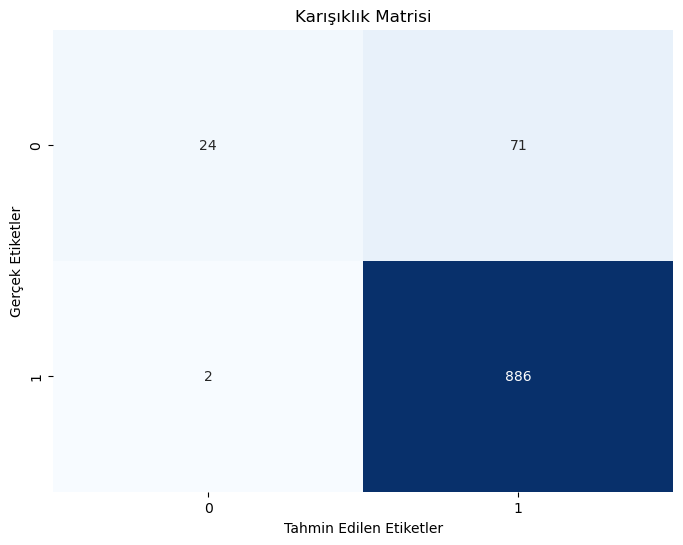

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Karışıklık matrisini hesaplama
cm = confusion_matrix(y_test, lr_predictions)

# Karışıklık matrisini görselleştirme
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Tahmin Edilen Etiketler')
plt.ylabel('Gerçek Etiketler')
plt.title('Karışıklık Matrisi')
plt.show()

In [39]:
from sklearn.model_selection import GridSearchCV

# Hiperparametreler için arama alanını tanımlayalım
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# GridSearchCV ile en iyi hiperparametreleri bulma
grid_search = GridSearchCV(LogisticRegression(solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train_tfidf, y_train)

# En iyi hiperparametreleri ve bu hiperparametrelerle elde edilen en iyi doğruluğu yazdırma
print("En iyi hiperparametreler:", grid_search.best_params_)
print("En iyi doğruluk:", grid_search.best_score_)

# En iyi hiperparametrelerle modeli eğitme
best_lr_model = grid_search.best_estimator_

En iyi hiperparametreler: {'C': 10, 'penalty': 'l2'}
En iyi doğruluk: 0.936926389710661


In [44]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Google Drive dosya URL'si ve dosya ID'si
url = 'https://drive.google.com/uc?id=1GdMMm_e2nwbtrK_PpSP21ab5poiB-qQK'
output = 'amazon_reviews.csv'

# Dosyayı indir
gdown.download(url, output, quiet=False)

# Veriyi okuma
data = pd.read_csv(output)

# "sentiment" sütununu oluşturma
data['sentiment'] = data['overall'].apply(lambda x: 'positive' if x >= 3 else 'negative')

# Yorum uzunluğunu yeni bir sütun olarak ekleyelim
data['review_length'] = data['reviewText'].apply(lambda x: len(str(x)))

# TF-IDF vektörlerini ve yorum uzunluğunu birleştirme
X_length = data[['review_length']]
y = data['sentiment']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_length, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini eğitme
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Modeli test verisiyle değerlendirme
predictions = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Modelin doğruluk oranı: {accuracy:.4f}")

Downloading...
From: https://drive.google.com/uc?id=1GdMMm_e2nwbtrK_PpSP21ab5poiB-qQK
To: C:\Users\Modalog\amazon_reviews.csv
100%|██████████| 1.60M/1.60M [00:00<00:00, 4.31MB/s]


Modelin doğruluk oranı: 0.9257


In [48]:
import pandas as pd
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Veriyi okuma
data = pd.read_csv('amazon_reviews.csv')

# Yorum uzunluğunu ve noktalama işaretlerinin sayısını hesaplama
data['review_length'] = data['reviewText'].apply(lambda x: len(str(x)))
data['punctuation_count'] = data['reviewText'].apply(lambda x: sum([1 for char in str(x) if char in string.punctuation]))

# "overall" sütununu "sentiment" sütununa dönüştürme
data['sentiment'] = data['overall'].apply(lambda x: 'positive' if x > 3 else 'negative')

# Yorum uzunluğu ve noktalama işaretlerinin sayısını kullanarak özellikleri ve hedefi ayarlama
X = data[['review_length', 'punctuation_count']]
y = data['sentiment']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini eğitme
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Modeli test verisiyle değerlendirme
predictions = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Modelin doğruluk oranı: {accuracy:.4f}")

Modelin doğruluk oranı: 0.9023


In [49]:
# Ünlem işareti sayısını hesaplama
data['exclamation_count'] = data['reviewText'].apply(lambda x: str(x).count('!'))

# Yorum uzunluğu, noktalama işaretlerinin sayısı ve ünlem işareti sayısını kullanarak özellikleri ayarlama
X = data[['review_length', 'punctuation_count', 'exclamation_count']]
y = data['overall']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini eğitme
lr_model_exclamation = LogisticRegression(max_iter=1000)
lr_model_exclamation.fit(X_train, y_train)

# Modeli test verisiyle değerlendirme
predictions_exclamation = lr_model_exclamation.predict(X_test)
accuracy_exclamation = accuracy_score(y_test, predictions_exclamation)
print(f"Modelin doğruluk oranı: {accuracy_exclamation:.4f}")

Modelin doğruluk oranı: 0.7955


C:\Users\Modalog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [50]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Veriyi yükleme
data = pd.read_csv("amazon_reviews.csv")

# Yorum uzunluğunu, noktalama işaretlerinin sayısını ve ünlem işareti sayısını hesaplama
data['review_length'] = data['reviewText'].apply(lambda x: len(str(x)))
data['punctuation_count'] = data['reviewText'].apply(lambda x: sum([1 for char in str(x) if char in string.punctuation]))
data['exclamation_count'] = data['reviewText'].apply(lambda x: str(x).count('!'))

# Yorum uzunluğu, noktalama işaretlerinin sayısı ve ünlem işareti sayısını kullanarak özellikleri ve hedefi ayarlama
X = data[['review_length', 'punctuation_count', 'exclamation_count']]
y = data['overall']

# Veriyi ölçeklendirme
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini eğitme
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Modeli test verisiyle değerlendirme
predictions = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Modelin doğruluk oranı: {accuracy:.4f}")

Modelin doğruluk oranı: 0.7955


In [55]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Veriyi okuma
data = pd.read_csv("amazon_reviews.csv")

# Faydalı bulunma oranını hesaplama
data['helpful_rate'] = data['helpful_yes'] / (data['helpful_no'] + data['helpful_yes'] + 0.0001)

# Faydalı bulunma oranını kullanarak özellikleri ve hedefi ayarlama
X = data[['helpful_rate']]
y = data['overall']

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini eğitme
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Modeli test verisiyle değerlendirme
predictions = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Modelin doğruluk oranı: {accuracy:.4f}")

Modelin doğruluk oranı: 0.7955


In [58]:
import numpy as np

In [65]:
import pandas as pd
import gdown
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np
import random

# Google Drive dosya URL'si ve dosya ID'si
url = 'https://drive.google.com/uc?id=1GdMMm_e2nwbtrK_PpSP21ab5poiB-qQK'
output = 'amazon_reviews.csv'

# Dosyayı indirme
gdown.download(url, output, quiet=False)

# Veriyi yükleme
data = pd.read_csv(output)

# Yorum uzunluğunu ve noktalama işaretlerinin sayısını hesaplama
data['review_length'] = data['reviewText'].apply(lambda x: len(str(x)))
data['punctuation_count'] = data['reviewText'].apply(lambda x: sum([1 for char in str(x) if char in string.punctuation]))

# Yardımcı olma oranını hesaplama
data['helpful_rate'] = data['helpful_yes'] / (data['helpful_no'] + 0.0001)

# Özellikleri ve hedefi ayarlama
X = data[['review_length', 'punctuation_count', 'helpful_rate']]
y = data['overall']  # overall sütununu kullanarak sentiment analizi yapma

# Veriyi eğitim ve test setlerine ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lojistik regresyon modelini eğitme
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)

# Modeli test verisiyle değerlendirme
predictions = lr_model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Modelin doğruluk oranı: {accuracy:.4f}")

# 10 rastgele yorum seçme
random.seed(42)
selected_reviews = random.sample(data['reviewText'].tolist(), 10)

# Seçilen yorumları ekrana yazdırma
for i, review in enumerate(selected_reviews, 1):
    print(f"{i}. Yorum: {review}")

# Seçilen yorumları model kullanarak sentiment analizi yapma
sample_predictions = lr_model.predict(X_test)

# Sonuçları ekrana yazdırma
for i, prediction in enumerate(sample_predictions, 1):
    print(f"{i}. Yorumun Tahmini Duygusu (overall): {prediction}")

Downloading...
From: https://drive.google.com/uc?id=1GdMMm_e2nwbtrK_PpSP21ab5poiB-qQK
To: C:\Users\Modalog\amazon_reviews.csv
100%|██████████| 1.60M/1.60M [00:00<00:00, 4.51MB/s]


Modelin doğruluk oranı: 0.7945
1. Yorum: Great memory card! Got this on one Amazon's daily deals at a terrific price! Getting ready to upgrade my cell phone and want to have a larger capacity memory card ready to go. This is just what I needed!
2. Yorum: Got it for my Note 10.1 and it's great being able to pop it into my computer via the adapter to load large amounts of pictures on and then back into my tablet. Kinda wishing I got a larger capacity one.
3. Yorum: It's fast, its small, its pretty cheap.  I put one in a usb reader to use as a thumb drive.
4. Yorum: This chip is super fast.  If you're going to use it in an Android device, I recommend formatting it in NTFS.
5. Yorum: So far so good works as described and on my LG Motion 4g android smartphone.  Speed is pretty good too even though it reverts back to class 10 on this phone.
6. Yorum: I have 2.Phone for over a year and no problems.Use with adapter in camera and laptop for 4-5 months without any trouble.Will continue to use Sa

C:\Users\Modalog\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
